## Käbbel importerare

Denna funktion läser allt käbbel från regeringens hemsida och sparar ner skiten i en fil: kabbel.txt
- datasize kan sättas till hur många sidor som ska hämtas


### Läs in fil och skapa ordvektor

Denna läser in orden från ovan skapade fil och bygger en data av den som vi använder som träningsdata

In [2]:
import numpy as np
import urllib.request, json, re
import pprint as pp
import tensorflow as tf
import re

from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import time
import datetime


import random

In [3]:


def file_to_json(filename):
    with open(filename,encoding="utf-8") as f:
        data = json.loads(f.read())
        return data

def kabbel_to_vec(jsondata):
    speech = []
    classes = []
    person = []
    words = []
    for sample in jsondata:
        cleaned = re.sub(r'[.|,]', '', sample["kabbel"])
        words += cleaned.lower().split()
        speech.append(cleaned)
        classes.append(sample["parti"])
        person.append(sample["talare"])

    #print(speech)
    #data = tf.compat.as_str(speech).split()
    return speech, classes, person




Läs in olika delar och tilldela X och Y i vår modell

In [4]:

jsondata = file_to_json("kabbel_big.txt")
print("Exempel på ett sample ur datan: \n"+json.dumps(jsondata[:2], indent=4))


speech, classes, person = kabbel_to_vec(jsondata)

print("Classes: {0}... \n\nSpeech:{1}...".format(classes[:3], speech[:3]))

Exempel på ett sample ur datan: 
[
    {
        "kabbel": "jag ska fatta mig kort.",
        "parti": "SD",
        "talare": "Paula Bieler (SD)"
    },
    {
        "kabbel": "jag har redan redogjort f\u00f6r huvudargumentationen bakom detta,",
        "parti": "SD",
        "talare": "Paula Bieler (SD)"
    }
]
Classes: ['SD', 'SD', 'SD']... 

Speech:['jag ska fatta mig kort', 'jag har redan redogjort för huvudargumentationen bakom detta', 'men för att sammanfatta kan vi konstatera att vi har en situation i dagsläget där endera av två olika scenarier har utspelat sig de senaste åren']...


## Anpassning av träningsdata (sample=X) och klassificering (Y)

Vi konverterar varje sample till en träningsvektor av längden `len(unika antal ord)` och värde `n` för antal förekomst per ord

Vi konverterar varje klasificering till en vektor som beskriver klasserna

In [5]:

def samples_to_vocab(samples):
    all_unique_words = list(set(' '.join(samples).split(' '))) 
    word_to_idx = {i:w for w,i in enumerate(all_unique_words)}
    idx_to_word = {i:w for i,w in enumerate(all_unique_words)}
    return word_to_idx, idx_to_word

def sample_to_vec(sample, wi):
    vocabular = wi
    sample_words = np.array(sample.split(" "))
    vec = np.array([wi[x] for x in sample_words])
    one_hot = np.zeros([len(vec), len(vocabular)])
    one_hot[np.arange(len(vec)),vec] = 1
    one_hot = np.sum(one_hot,axis=0)
    return vec,one_hot

def samples_to_train(samples):
    vocabulary, iw = samples_to_vocab(samples)
    sample_vector = []
    for sample in samples:
        _, x = sample_to_vec(sample, vocabulary)
        sample_vector.append(x)
    return np.matrix(sample_vector).reshape((len(samples),len(vocabulary))).T, vocabulary, iw


In [6]:
test_data =[
    {
        "talare": "Joakim",
        "parti": "S",
        "kabbel": "jag ska, fatta mig kort."
    },
    {
        "talare": "Björn",
        "parti": "SD",
        "kabbel": "jag har redan redogjort f\u00f6r huvudargumentationen bakom detta,"
    }
]

test_samples,test_parti, test_classes = kabbel_to_vec(test_data)

#test_samples = ["Apan är Bäst", "Joakim är Bäst i klassen i alla fall","Joakim"]
#test_classes = ["Apan", "Joakim","Joadkim"]

print(test_samples)
a, b, c = samples_to_train(test_samples)
print(a)
samples_to_train(test_classes)

['jag ska fatta mig kort', 'jag har redan redogjort för huvudargumentationen bakom detta']
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


(matrix([[ 0.,  1.],
         [ 1.,  0.]]), {'Björn': 0, 'Joakim': 1}, {0: 'Björn', 1: 'Joakim'})

In [7]:
def print_data_info(speech,classes,test_index=0):
    X_train,vocabulary_x, _ = samples_to_train(speech)
    Y_train,vocabulary_y, _ = samples_to_train(classes)
    print("Antal unika ord (features X):\t",X_train.shape[0])
    print("training samples m:\t\t",Y_train.shape[1])
    print("unika klassificeringar (Y):\t",Y_train.shape[0])
    vec, one = sample_to_vec(speech[test_index],vocabulary_x)
    print("X:")
    print("Original: {0}{1}".format(speech[test_index][:70],"..." if len(speech[test_index])>70 else ""))
    print("Vokabulär: {0}".format([x for x in vocabulary_x][:10]))
    print("x0 :\n{0}".format(vec))
    print("x0 compressed:\n{0}\n".format(X_train)) 
    print("Y:")
    print([x for x in vocabulary_y])
    print("y0 compressed:\n{0}".format(Y_train)) 
    assert X_train.shape[1] == Y_train.shape[1] , 'Det måste finnas lika många X som Y:n'

def print_shape_info(X_train,Y_train):
    print("number of training examples: {0}".format(X_train.shape[1]))
    print("X_train shape: {0}".format(str(X_train.shape)))
    print("Y_train shape: {0}".format(str(Y_train.shape)))
  

In [8]:
test_samples = ["Apan är Bäst Bäst Bäst", "Joakim är Bäst i klassen i alla fall","Joakim","Hejhej","Joakim"]
test_classes = ["Apan", "Joakim","Joadkim","Annan","Joakim"]



X_samp,vocabulary_x, iw = samples_to_train(test_samples)
Y_samp,vocabulary_y ,iw= samples_to_train(test_classes)

print_shape_info(X_samp, Y_samp)
print_data_info(test_samples,test_classes,test_index=0)

number of training examples: 5
X_train shape: (9, 5)
Y_train shape: (4, 5)
Antal unika ord (features X):	 9
training samples m:		 5
unika klassificeringar (Y):	 4
X:
Original: Apan är Bäst Bäst Bäst
Vokabulär: ['i', 'Bäst', 'alla', 'Hejhej', 'är', 'Apan', 'fall', 'Joakim', 'klassen']
x0 :
[5 4 1 1 1]
x0 compressed:
[[ 0.  2.  0.  0.  0.]
 [ 3.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.]
 [ 0.  1.  0.  0.  0.]]

Y:
['Joadkim', 'Joakim', 'Annan', 'Apan']
y0 compressed:
[[ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]]


In [9]:
def get_stop_words(X, iw, top=10):

    X_samp_sum = np.sum(X,axis=1)
    
    idx = np.argsort(-X_samp_sum, axis=0)
    iw_ar = [w for (i,w) in iw.items()]
    count = X_samp_sum[idx[:top]].flatten()
    labels = np.asarray(iw_ar)[idx[:top]]
    a = count.tolist()[0]
    b = labels.flatten().tolist()
    z = dict(zip(b,a))
    res = []
    for k,v in z.items():
        res.append("{0}\t{1:20}\t[{2}]".format(len(res)+1,k,v).expandtabs(2))
    print("\n".join(res))
    return idx

def remove_features(X_samp, del_idx, iw, remove):
    #del_idx = get_stop_words(X_samp,iw,remove)
    iwr = [w for (i,w) in iw.items()]
    iwr = np.delete(iwr, del_idx[:remove], axis=0)
    X_red = np.delete(X_samp, del_idx[:remove], axis=0)
    
    assert X_samp.shape[0] == X_red.shape[0]+remove
    return X_red, iwr


In [10]:
remove = 2

X_samp,_, iw = samples_to_train(test_samples)
del_idx = get_stop_words(X_samp,iw,remove)
X_red, iwr = remove_features(X_samp,del_idx, iw, remove)

print(iwr)



1 Bäst                  [4.0]
2 Joakim                [3.0]
['i' 'alla' 'Hejhej' 'är' 'Apan' 'fall' 'klassen']


In [11]:
def shuffle(X,Y, seed=1):
    np.random.seed(1)
    randomize = np.arange(X.shape[1])
    np.random.shuffle(randomize)
    #blanda kolumnerna
    X = X[:,randomize]
    Y = Y[:,randomize]
    return X,Y

In [12]:
np.random.seed(2)
a = np.random.rand(2,5)
b,c  = shuffle(a,a,1)
pp.pprint(a)
pp.pprint(b)
pp.pprint(c)

array([[ 0.4359949 ,  0.02592623,  0.54966248,  0.43532239,  0.4203678 ],
       [ 0.33033482,  0.20464863,  0.61927097,  0.29965467,  0.26682728]])
array([[ 0.54966248,  0.02592623,  0.4203678 ,  0.4359949 ,  0.43532239],
       [ 0.61927097,  0.20464863,  0.26682728,  0.33033482,  0.29965467]])
array([[ 0.54966248,  0.02592623,  0.4203678 ,  0.4359949 ,  0.43532239],
       [ 0.61927097,  0.20464863,  0.26682728,  0.33033482,  0.29965467]])


In [13]:
def split_train_dev_test(X,Y,ratio=.5):
    np.random.seed(2)
    m = X.shape[1]
    m_train = int(np.floor((X.shape[1]*ratio)))
    m_bi = int((m - m_train)/2)
    
    X_orig, Y_orig = shuffle(X,Y)
    
    X_train, X_dev, X_test = X_orig[:,:m_train], X_orig[:,m_train:m_train+m_bi], X_orig[:,m_train+m_bi:]
    Y_train, Y_dev, Y_test = Y_orig[:,:m_train], Y_orig[:,m_train:m_train+m_bi], Y_orig[:,m_train+m_bi:]
    print(m_train,m_bi+m_train)
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [14]:

#print_data_info(speech,classes)
x_train,vocabulary_x,_ = samples_to_train(test_samples)
y_train,vocabulary_y,_ = samples_to_train(test_classes)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_train_dev_test(x_train,y_train,ratio=.9)
m = x_train.shape[1]
print('m:{0}'.format(m))
print('m_train:{0}'.format(X_train.shape[1]))
print('m_dev:{0}'.format(X_dev.shape[1]))
print('m_test:{0}'.format(X_test.shape[1]))

print(x_train)
print(X_train.shape)
print(Y_train.shape)

assert m == Y_train.shape[1]+Y_dev.shape[1] + Y_test.shape[1]
assert m == X_train.shape[1]+X_dev.shape[1] +X_test.shape[1] #"matrisen harinte samma features"
assert X_train.shape[0] == X_dev.shape[0] #matrisen behåller formen features


4 4
m:5
m_train:4
m_dev:0
m_test:1
[[ 0.  2.  0.  0.  0.]
 [ 3.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.]
 [ 0.  1.  0.  0.  0.]]
(9, 4)
(4, 4)


In [51]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(shape=[n_x,None],dtype=tf.float32,name="X")
    Y = tf.placeholder(shape=[n_y,None],dtype=tf.float32,name="Y")
    return X, Y

## Initiera parametrar


In [16]:
def initialize_params(hyperparameters):
    """Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3"""
    
    layer_dims = hyperparameters['layer_dims']
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = tf.get_variable(name="W"+str(l),shape=[layer_dims[l],layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(l)] = tf.get_variable(name="b"+str(l),shape=[layer_dims[l],1],initializer=tf.zeros_initializer())

        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters
    

In [17]:
def init_hyperparams(layer_dims):
    hyperparameters = {}
    hyperparameters['layer_dims'] = layer_dims
    
    return hyperparameters

In [18]:

tf.reset_default_graph() #nollställ modell
hyperparameters = init_hyperparams(layer_dims=[X_train.shape[0],25,12,Y_train.shape[0]])
paramteters = initialize_params(hyperparameters)

pp.pprint(paramteters)

{'W1': <tf.Variable 'W1:0' shape=(25, 9) dtype=float32_ref>,
 'W2': <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>,
 'W3': <tf.Variable 'W3:0' shape=(4, 12) dtype=float32_ref>,
 'b1': <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>,
 'b2': <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>,
 'b3': <tf.Variable 'b3:0' shape=(4, 1) dtype=float32_ref>}


## Forward propagation

In [19]:
def forward_propagation(X, hyperparameters, parameters):
    layer_dims = hyperparameters['layer_dims']
    L = len(layer_dims)-1
  
    Zi = {}
    Ai = {}
    Ai[0] = X
    for l in range(1,L+1):
        Zi[l] = tf.matmul(parameters['W'+str(l)],Ai[l-1])+parameters['b'+str(l)]
        Ai[l] = tf.nn.relu(Zi[l])
        #print("ff"+str(l)+" "+'W'+str(l)+"x"+"Ai["+str(l-1)+"] + "+'b'+str(l))

    return Zi[L]


    

In [20]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(X_train.shape[0], Y_train.shape[0])
    parameters = initialize_params(hyperparameters)
    Z3 = forward_propagation(X, hyperparameters, parameters)
    print("Z3 = " + str(Z3))



ValueError: too many values to unpack (expected 2)

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(X_train.shape[0], Y_train.shape[0])
    parameters = initialize_params(hyperparameters)
    Z3 = forward_propagation(X, hyperparameters, parameters)
    print("Z3 = " + str(Z3))



### Kostnadsfunktion

In [ ]:
def compute_cost(Z3, Y):
    
    #    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    #biases = tf.Variable(tf.zeros([num_labels]))
   # weights = tf.Variable(tf.truncated_normal([Z3.shape[0], Z3.shape[1]]))
   # biases = tf.Variable(tf.zeros([Z3.shape[1]]))
  
    # Training computation.
   # logits = tf.transpose(tf.matmul(Z3, weights) + biases )
    logits = tf.transpose(Z3 + Z3)
    labels = tf.transpose(Y)
    
    # L2_regularization_cost = lambd/(2*m)*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    #kostnadsfunktion ej regulariserad.
    #logits = tf.matmul(tf_train_dataset, weights) + biases 
    # Original loss function
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) )
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost
    

In [59]:
def compute_cost_with_regularization(Z3, Y, parameters, lambd):

    layer_dims = hyperparameters['layer_dims']
    L = len(layer_dims)-1
    L2_regularization_cost = tf.Variable(0,dtype=tf.float32)
    for l in range(1,L):
        L2_regularization_cost +=  tf.nn.l2_loss(parameters['W'+str(l)]) 


    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels)
    
    cost = tf.reduce_mean(loss + lambd*L2_regularization_cost)

    
    return cost

In [ ]:
layer_dims = hyperparameters['layer_dims']
L = len(layer_dims)-1
for l in range(1,L):
        print(l)

In [ ]:
tf.reset_default_graph()
X_train,vocabulary_x, iw = samples_to_train(test_samples)
Y_train,vocabulary_y ,iw= samples_to_train(test_classes)

with tf.Session() as sess:
    X, Y, mb = create_placeholders(X_train.shape[0], Y_train.shape[0])
    parameters = initialize_params(hyperparameters)
    Z3 = forward_propagation(X, hyperparameters, parameters)
    cost = compute_cost_with_regularization(Z3, Y,parameters,.1,mb)
    print("cost = " + str(cost))

In [64]:
def random_mini_batches(X_train, Y_train, minibatch_size, seed):
    """Tar in hela train och delar upp i x antal minibatch_size
        med randomiserade kolumner (träningsexempel)"""
    cuts = int(X_train.shape[1] / minibatch_size)
    X_train, Y_train = shuffle(X_train, Y_train, seed)
    minibatch_X = []
    minibatch_Y = []
    minibatches = []

    for i in range(0,cuts+1):
        minibatches.append((X_train[:,i*minibatch_size:(i+1)*minibatch_size],Y_train[:,i*minibatch_size:(i+1)*minibatch_size]))

    return minibatches
    
    

In [ ]:
a = np.floor(np.random.rand(3,11)*10)
minibatches = random_mini_batches(a,a,3,1)

print(a)
for (_,b) in minibatches:
    pp.pprint(b)

print("\nbatch lengths: {0}".format([b.shape[1] for (_,b) in minibatches]))
print(sum([b.shape[1] for (_,b) in minibatches]))
assert sum([b.shape[1] for (_,b) in minibatches]) == a.shape[1]


# Modell
Här börjar vi om fast använder ovan funktioner

In [65]:
jsondata = file_to_json("kabbel.txt")
speech, classes, person = kabbel_to_vec(jsondata)

X_orig,vocabulary_x,iwx = samples_to_train(speech)
Y_orig,vocabulary_y,iwy = samples_to_train(classes)

#REMOVE STOP WORDS
remove = 29
print("{0} most used words:".format(remove))
del_idx = get_stop_words(X_orig,iwx,remove)
X_orig, iwx_red = remove_features(X_orig,del_idx,iwx,remove)

print(X_orig)
row_sums = np.sum(X_orig,axis=1)
print(iwx_red)
#NORMALIZE X // not used
#X_orig = X_orig / row_sums
#print(X_orig)

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_train_dev_test(X_orig,Y_orig,ratio=.80)
#print_data_info(speech,classes,test_index=0)

print(vocabulary_y)
print("train:{0} dev:{1} test:{2}".format(X_train.shape,X_dev.shape,X_test.shape))


29 most used words:
1 att                   [1667.0]
2 det                   [1271.0]
3 och                   [1058.0]
4 i                     [947.0]
5 är                    [839.0]
6 som                   [837.0]
7 har                   [633.0]
8 för                   [612.0]
9 vi                    [565.0]
10  en                    [528.0]
11  jag                   [480.0]
12  på                    [404.0]
13  till                  [401.0]
14  inte                  [389.0]
15  av                    [381.0]
16  de                    [376.0]
17  om                    [373.0]
18  den                   [354.0]
19  med                   [347.0]
20  man                   [305.0]
21  ett                   [297.0]
22  kan                   [214.0]
23  ska                   [209.0]
24  också                 [192.0]
25  när                   [167.0]
26  här                   [163.0]
27  detta                 [160.0]
28  regeringen            [155.0]
29  men                   [141.0]
[[ 0.  0.

In [70]:


#epoch = antal iterationer över samma samples fast med olika rand. dist. (som montecarlo eller nått)


def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.1,
          num_epochs = 3000, minibatch_size = 512, print_cost = True, lambd = 0.9):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results  
    seed = 1                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    

    
    #skapa tomma placeholders för vår data
    X, Y = create_placeholders(n_x,n_y)
    CLR_learning_rate = tf.Variable(learning_rate,tf.float32)
    
    #skapa hyperparameter om lager och units samt aktiveringsfunktioner per lager ()
    hyperparameters = init_hyperparams(layer_dims=[X_train.shape[0],10,5,Y_train.shape[0]])
    #skapa W b i varje lager
    parameters = initialize_params(hyperparameters)

    #initiera beräkningsgrafen för forward/backward prop
    Z3 = forward_propagation(X,hyperparameters,parameters)

    #initiera beräkningsgraf för kostnaden 
    cost = compute_cost_with_regularization(Z3, Y, parameters, lambd) #compute_cost(Z3,Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    #nu med learning rate decay
    optimizer = tf.train.AdamOptimizer(learning_rate=CLR_learning_rate, name='Adam').minimize(cost)
   
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    epoch_print = 100
    e_count = 0
    tr_acc =[]
    t_acc=[]
    
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        model_start_time = time.time()
        last_time = model_start_time
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed +=1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            cycl = len(minibatches)
            minlr = 0.001
            mbi = 0
            for minibatch in minibatches:
                mbi +=1
                #lr = 0.001+(mbi*(maxlr-0.001)/cycl)
                lr = 0.001+mbi*0.001
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, 
                                                                            Y: minibatch_Y,
                                                                            CLR_learning_rate: lr})
            
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and (epoch % epoch_print == 0 and epoch > 0) or epoch == 10:
                
                t_now = time.time()
                e_count = epoch-e_count
                e_time = (t_now-last_time)/e_count
               
                est_end = (num_epochs - epoch)*e_time + t_now
                st = datetime.datetime.fromtimestamp(est_end).strftime('%Y-%m-%d %H:%M:%S')
                if epoch == 10:
                    print("{0}".format(datetime.timedelta(seconds=(est_end-t_now))))
                print("Cost after epoch {0}: {1} - epoch time {2} - est end: {3}".format(epoch, epoch_cost,e_time,st))
                last_time = t_now
                t_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Z3), tf.argmax(Y)), "float"))
                
                tr_acc.append(t_accuracy.eval({X: X_train, Y: Y_train}))
                t_acc.append(t_accuracy.eval({X: X_test, Y: Y_test}))
                
                plt.plot(np.squeeze(tr_acc))
                plt.plot(np.squeeze(t_acc))
                        
                plt.show()
                
                
            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)
                if costs[0] < epoch_cost:
                    print("SOMETHING IS WRONG - cost increase?!")
                    break
                
       

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print(hyperparameters)
        
         # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        return parameters



# Run the model below. 

number of training examples: 2217
X_train shape: (5165, 2217)
Y_train shape: (5, 2217)
0:13:35.995625
Cost after epoch 10: 2.6605343222618103 - epoch time 0.16352617740631104 - est end: 2017-09-25 23:19:15


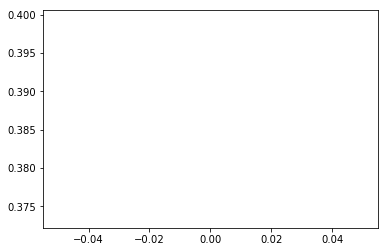

Cost after epoch 100: -0.49303705990314484 - epoch time 0.14908453358544244 - est end: 2017-09-25 23:18:02


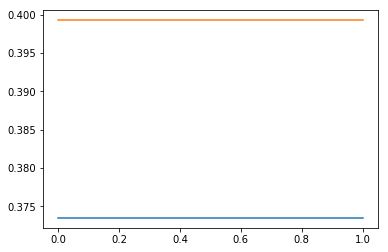

Cost after epoch 200: -2.7431244254112244 - epoch time 0.1352613015608354 - est end: 2017-09-25 23:16:56


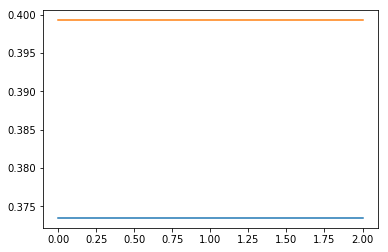

Cost after epoch 300: -4.993368744850159 - epoch time 0.07813232572455155 - est end: 2017-09-25 23:12:29


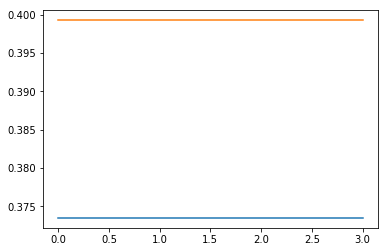

Cost after epoch 400: -7.2431042194366455 - epoch time 0.07037929580325172 - est end: 2017-09-25 23:12:00


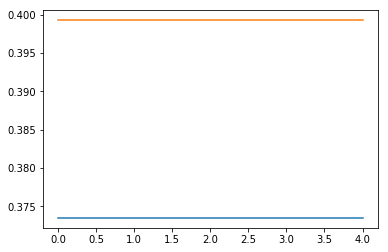

Cost after epoch 500: -9.493188381195068 - epoch time 0.05086035892881196 - est end: 2017-09-25 23:10:40


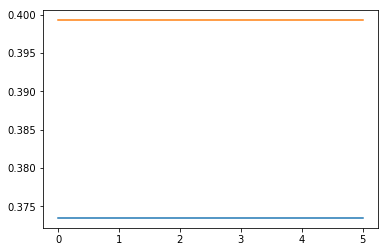

KeyboardInterrupt: 

In [71]:
start_time = time.time()
print_shape_info(X_train, Y_train)
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 5000,lambd = 0.9)

print("--- %s seconds ---" % (time.time() - start_time))

In [21]:

def ran_vec(length,n_min,n_max,log=False):
    vec = []
    random.seed(2)
    random.randint(1,1031)*10
    np.random.randint(1, 13, size=length)
    
    for i in range(length):
        vec[np.rand()]

In [50]:
lrate = []
for l in range(2,6):
    layer_dims = np.random.randint(1, 13, size=l)
    learning_rate = np.random.exponential(1)
    lrate.append(learning_rate)
    print(learning_rate)
    
#learning_rate .1 .01 .001 (10)
#layers 2-6 (4)
#units 2, 3, 4, 5 (4)
#lambd .9

plt.plot(lrate)
plt.show()


TypeError: exponential() got an unexpected keyword argument 'base'

In [42]:
np.random.exponential(100)

125.03817021620466

# Test av modellen på ny data
en predict-funktion som kör modellens forward-pass och använder softmax för klassificering till någon av de giltiga Y-värdena

In [181]:
def predict(speech, parameters, vocabulary):
        sample_to_vec(speech, vocabulary)

In [184]:
def predict(X_samp):
    init = tf.global_variables_initializer()
    X = tf.placeholder(shape=[X_train.shape[0],None],dtype=tf.float32,name="X")
    pred = forward_propagation(X,hyperparameters,parameters)
    classify = tf.nn.softmax(tf.transpose(pred))
    session = tf.Session()
    session.run(init)
    b = session.run(classify, feed_dict={X: X_samp})
    return(b)

In [263]:
#XS_train, XS_dev, XS_test, YS_train, YS_dev, YS_test = split_train_dev_test(speech,classes,ratio=.82)
sample_i = 1222
b = predict(X_test[:,sample_i])
c = np.zeros(b.shape[1]).astype(int)

c[np.argmax(b)] = 1
print(speech[sample_i])
print(iwy[np.argmax(b)])
print(classes[(sample_i-3)])

bild
L
S


In [193]:
def samples_to(speech,classes,idx):
    xvocabulary, iwx = samples_to_vocab(speech)
    yvocabulary, iwy = samples_to_vocab(classes)
    
    _, x = sample_to_vec(speech[idx], xvocabulary)
    _, y = sample_to_vec(classes[idx], yvocabulary)
    return speech[idx],classes[idx],x.T,y, iwx,iwy
    

In [194]:
def sentence_to_vec(sentence,vocabular):
    sample_words = np.array(sentence.split(" "))
    vec = np.array([vocabular.get(x) for x in sample_words if vocabular.get(x) is not None])
    one_hot = np.zeros([len(vec), len(vocabular)])
    one_hot[np.arange(len(vec)),vec] = 1
    one_hot = np.sum(one_hot,axis=0)
    return one_hot, vec

In [259]:
def test_predict(sentence,full_vocabulary,classY):
    str_s = sentence.lower()
    jvoc = np.asarray([k for k,v in full_vocabulary.items()])
    print(jvoc.shape)
    jvoc, iwx_red = remove_features(jvoc,del_idx,iwx,remove)

    jvoc = dict(zip(jvoc,range(len(jvoc))))
    
    xr,_ =sentence_to_vec(str_s,jvoc)
    xr = xr.reshape(xr.shape[0],1)
    pred = predict(xr)
    c = np.zeros(pred.shape[1]).astype(int)
    c[np.argmax(pred)] = 1
    
    print("{0}\n{1} ---> {2}\n\n\n{3}\n".format(str_s,x,pred,classY[np.argmax(pred)]))
    

In [258]:
print(X_orig.shape)
str_s,str_c,x,y,iwx,iwy =    samples_to(speech,classes,1)
sample_i = 2622

jvoc = np.asarray([k for k,v in vocabulary_x.items()])
print(jvoc.shape)
jvoc, iwx_red = remove_features(jvoc,del_idx,iwx,remove)

jvoc = dict(zip(jvoc,range(len(jvoc))))

test_predict("solidaritet",vocabulary_x,iwy)

(16506, 16604)
(16535,)
(16535,)
solidaritet
[ 0.  0.  0. ...,  0.  0.  0.] ---> [[  3.47265537e-04   6.30126847e-03   1.38636431e-04   1.40720919e-01
    1.26187308e-02   6.43577993e-01   1.88591093e-01   3.96953110e-05
    5.23801544e-04   2.20969305e-05   7.08431471e-03   3.41737104e-05]]


S



# SD (?)
Ok. inte klart ännu.